In [1]:
# ! pip install sentencepiece
# ! pip install torchtext torch transformers


In [2]:
import torch
print(torch.__version__)


2.7.1+cpu


In [ ]:
import pandas as pd
import numpy as np
import torch

from datasets import Dataset, DatasetDict
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DebertaV2Tokenizer
from transformers import AutoModelForSequenceClassification
from torch.optim import Adam

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter


In [4]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from utils.path_config import get_data_path
from utils.text_cleaning import clean_review_df
from utils.data_saving import save_with_rolling_backup
from utils.intent_mapping import apply_intent_mapping, inspect_potential_fp
import notebook_setup

Project root set to: D:\0) Abhay\04) SRH University Study Docs\Advance Programming\Python Files\Case Study Files
sys.path updated, project-level imports ready.


In [5]:
import os
import sys

models_path = os.path.abspath("../models")
if models_path not in sys.path:
    sys.path.append(models_path)

from shared import load_and_prepare_data, split_data, get_label_names


In [7]:
from datasets import Dataset, DatasetDict

# Load and prepare data
gold_df, label_encoder = load_and_prepare_data()
X_train, X_val, X_test, y_train, y_val, y_test = split_data(gold_df)

# Combine into DataFrames
train_df = pd.DataFrame({"merged_text": X_train, "label": y_train})
val_df   = pd.DataFrame({"merged_text": X_val, "label": y_val})
test_df  = pd.DataFrame({"merged_text": X_test, "label": y_test})

# Create Hugging Face DatasetDict
raw_datasets = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

# Load DeBERTa tokenizer
model_name = "microsoft/deberta-v3-small"
from transformers import DebertaV2Tokenizer

tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-small")


# Define tokenizer function
def tokenize_function(example):
    return tokenizer(
        example["merged_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenize and format
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Final datasets
train_dataset = tokenized_datasets["train"]
val_dataset   = tokenized_datasets["validation"]
test_dataset  = tokenized_datasets["test"]


Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Map:   0%|          | 0/409 [00:00<?, ? examples/s]

Map:   0%|          | 0/409 [00:00<?, ? examples/s]

In [ ]:
# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Merge into a DatasetDict
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Tokenization function
def tokenize_function(example):
    return tokenizer(
        example["merged_text"],
        padding="max_length",
        truncation=True,
        max_length=128  # You can increase to 256 or 512 if needed
    )

# Apply tokenization
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Format for PyTorch
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map:   0%|          | 0/1908 [00:00<?, ? examples/s]

Map:   0%|          | 0/409 [00:00<?, ? examples/s]

Map:   0%|          | 0/409 [00:00<?, ? examples/s]

#### DeBerta

In [ ]:
from transformers import AutoModelForSequenceClassification

label_names = list(label_encoder.classes_)
# Load DeBERTa model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_names)
)

# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1": f1_score(labels, predictions, average="weighted"),
    }


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Trainer for DeBERTa and RNN and their eval matrix

### DeBERTa training 

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import AutoModelForSequenceClassification

label_names = list(label_encoder.classes_)

model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small", 
    num_labels=len(label_names)
)


training_args = TrainingArguments(
    output_dir="./results_deberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
)
# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1": f1_score(labels, predictions, average="weighted"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\abhay\AppData\Local\Temp\ipykernel_21680\147211854.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
trainer.train()

c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,1.699200,1.160413,0.005000,0.682152,0.616435,0.682152,0.595189
2,0.687200,0.510492,0.005000,0.870416,0.826948,0.870416,0.844793
3,0.304000,0.294463,0.005000,0.921760,0.918661,0.921760,0.912759
4,0.136900,0.300019,0.005000,0.938875,0.933754,0.938875,0.934128
5,0.075900,0.277089,0.005000,0.943765,0.937677,0.943765,0.939398
6,0.045800,0.261159,0.005000,0.951100,0.945346,0.951100,0.947671
7,0.034300,0.260738,0.005000,0.953545,0.946838,0.953545,0.949788
8,0.024600,0.258933,0.005000,0.951100,0.944314,0.951100,0.947392


c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhay\AppData\Local\Programs\Python\

TrainOutput(global_step=960, training_loss=0.3759713890651862, metrics={'train_runtime': 8632.0395, 'train_samples_per_second': 1.768, 'train_steps_per_second': 0.111, 'total_flos': 505585717788672.0, 'train_loss': 0.3759713890651862, 'epoch': 8.0})

#### Evaluation of DeBERTa model

c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.9535452322738386
Precision: 0.9468378432882677
Recall: 0.9535452322738386
F1 Score: 0.9497877329921721

Classification Report:
                      precision    recall  f1-score   support

    CHECK_SALE_ITEMS       0.78      0.78      0.78         9
    CONNECT_TO_AGENT       1.00      0.88      0.93         8
             GOODBYE       1.00      0.83      0.91         6
               OTHER       0.00      0.00      0.00         3
      PRODUCT_SEARCH       0.97      0.95      0.96       103
         RETURN_ITEM       0.86      0.92      0.89        13
 SENTIMENT_COMPLAINT       0.92      0.89      0.91        38
    SENTIMENT_PRAISE       0.97      1.00      0.98       148
VIEW_PRODUCT_DETAILS       0.95      0.98      0.97        64
VIEW_RECOMMENDATIONS       0.94      0.94      0.94        17

            accuracy                           0.95       409
           macro avg       0.84      0.82      0.83       409
        weighted avg       0.95      0.95      0.95  

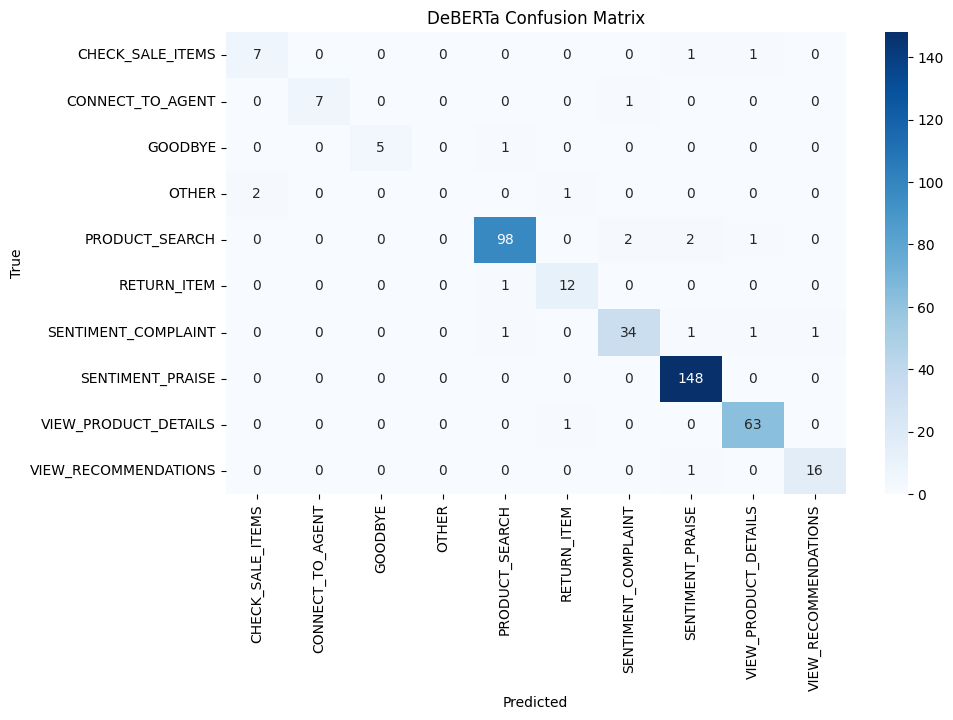

In [28]:

# Predict on test set
preds_output = trainer.predict(tokenized_datasets["test"])

# Extract predictions and true labels
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=1)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DeBERTa Confusion Matrix")
plt.show()
